In [345]:
# Importing all necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [346]:
# Collecting historical Infosys stock data from around 5 years ago till present

start_date = "2018-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

infy = yf.Ticker("JINDALSTEL.NS")
df = infy.history(start=start_date, end=end_date)

df = df[['Open', 'High', 'Low', 'Close']]

df.head()

,Open,High,Low,Close
Date,,,,
2018-01-01 00:00:00+05:30,202.050181,207.089091,201.160969,203.729813
2018-01-02 00:00:00+05:30,204.520243,205.310663,197.357095,200.963364
2018-01-03 00:00:00+05:30,202.099585,219.785145,202.099585,216.919891
2018-01-04 00:00:00+05:30,218.303118,248.981157,214.499248,241.620407
2018-01-05 00:00:00+05:30,240.088972,246.313504,233.864440,236.186295


In [347]:
df.to_csv('JINDALSTEL.csv')

In [348]:
# Considering only the closing price for model training

df = pd.read_csv('JINDALSTEL.csv')
df1 = df['Close'].values.reshape(-1, 1)

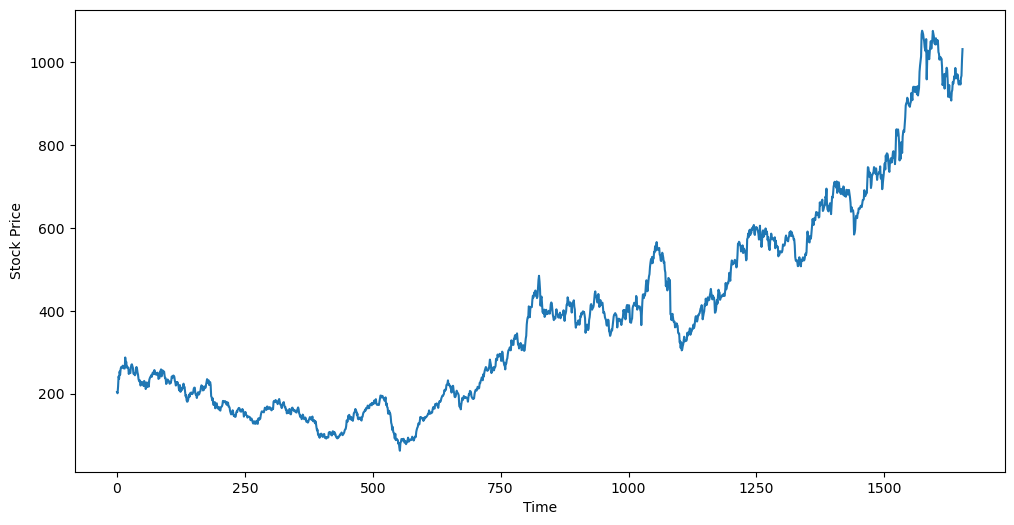

In [349]:
plt.figure(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.plot(df1)

In [350]:
# Making a 65-35 train-test split

train_size = int(len(df1) * 0.65)
train_data = df1[:train_size]
test_data = df1[train_size:]

scaler = MinMaxScaler(feature_range=(0, 1))

In [351]:
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.fit_transform(test_data)

In [352]:
# Function that will create a dataset with specific number of past days as features

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [353]:
# Creating the actual dataset with 100 timesteps

time_step = 100
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [354]:
# Creating the stacked LSTM model

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(100, 1)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

C:\Users\asus\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [355]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [356]:
# compilinig and fitting the model with early stopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping])

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 0.0749 - val_loss: 0.0312
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0103 - val_loss: 0.0061
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/ste

In [357]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [358]:
# Reversing the scaling for model performance assessment

train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [359]:
# Calculating Mean Absolute Percentage Error

train_mape = mean_absolute_percentage_error(y_train[0], train_predict[:, 0])
test_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0])

print(f"Train MAPE: {train_mape:.4f}")
print(f"Test MAPE:{test_mape:.4f}")

Train MAPE: 0.0233
Test MAPE:0.0197


In [360]:
# Calculating the Root Mean Squared Error

train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 17.373940064055635
Test RMSE: 18.016046429962536


In [361]:
# Calculating the R2 Score

train_r2 = r2_score(y_train[0], train_predict[:, 0])
test_r2 = r2_score(y_test[0], test_predict[:, 0])

print(f"Train R2 Score: {train_r2}")
print(f"Test R2 Score: {test_r2}")

Train R2 Score: 0.9912443199720601
Test R2 Score: 0.9891419464940624


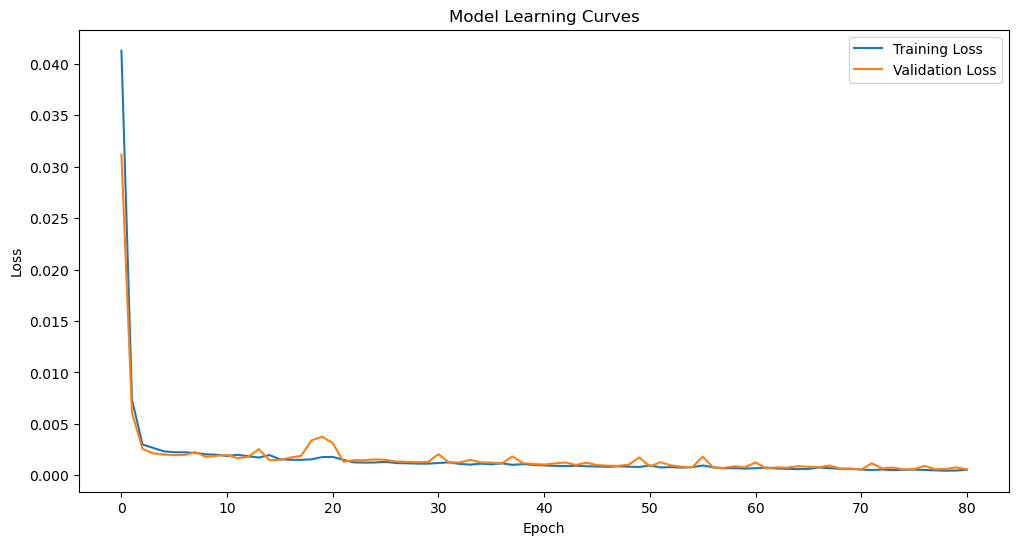

In [362]:
# Visualising the Model's learning curve

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

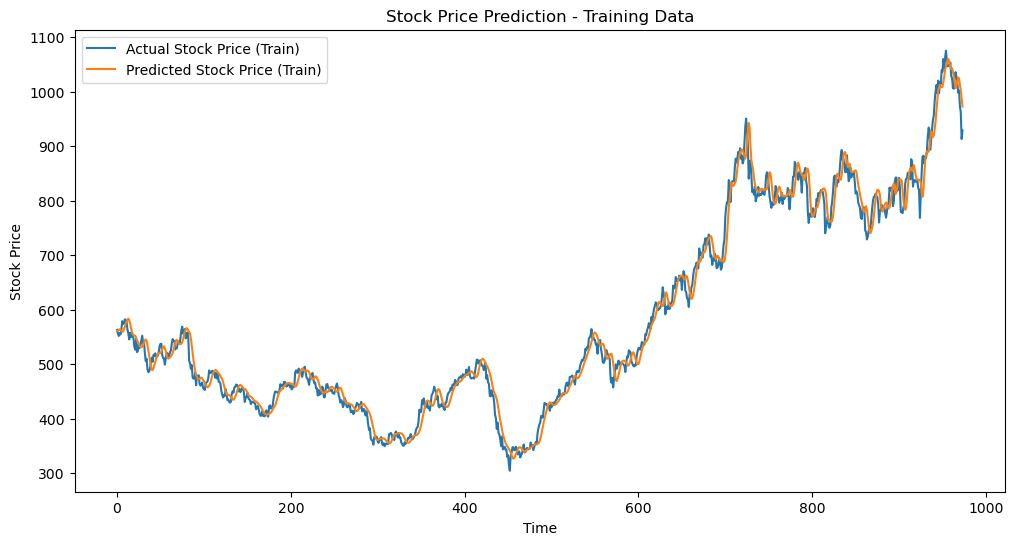

In [363]:
# Visualising how the model fit the training data

plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(train_scaled[-len(y_train[0]):]), label='Actual Stock Price (Train)')
plt.plot(train_predict, label='Predicted Stock Price (Train)')
plt.title('Stock Price Prediction - Training Data')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

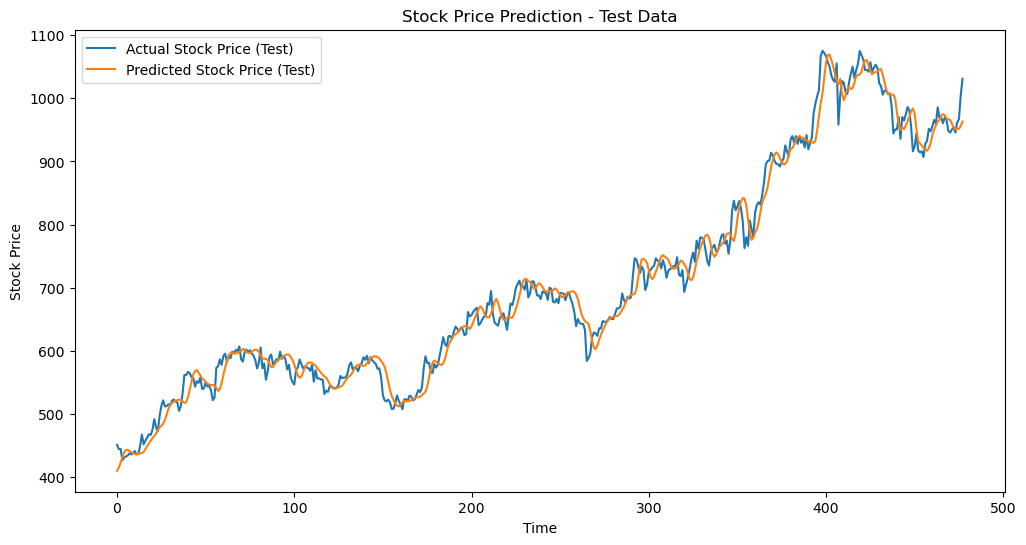

In [364]:
# Visualising how the model fit in the testing data

plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(test_scaled[-len(y_test[0]):]), label='Actual Stock Price (Test)')
plt.plot(test_predict, label='Predicted Stock Price (Test)')
plt.title('Stock Price Prediction - Test Data')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [365]:
# Predicting the next 30 days' performance

last_100_days = test_scaled[-100:]
predicted_prices = []

for _ in range(30):  
    X = last_100_days.reshape(1, 100, 1)
    pred = model.predict(X)
    predicted_prices.append(pred[0, 0])
    last_100_days = np.append(last_100_days[1:], pred)

predicted_prices = scaler_test.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

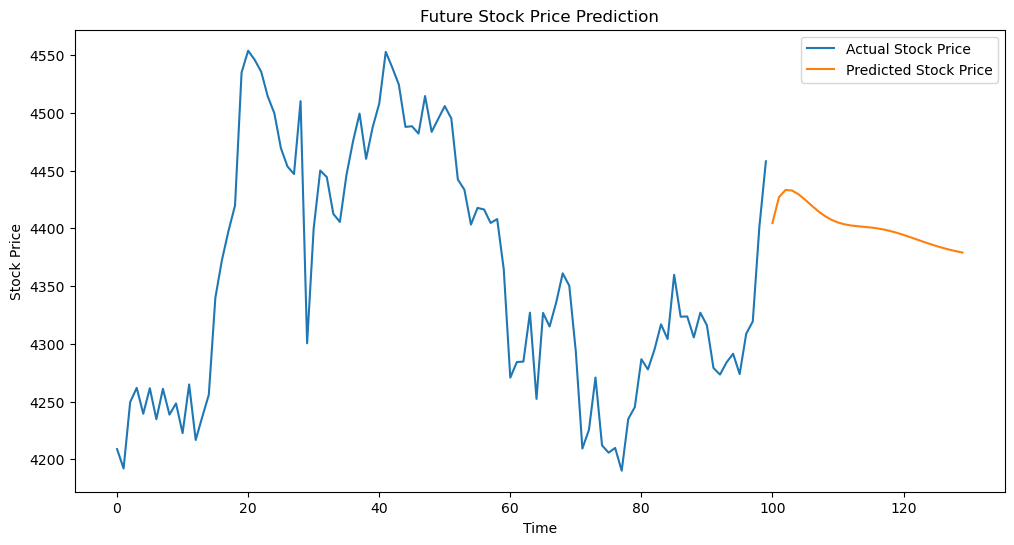

In [366]:
# Visualising the next 30 days' performance prediction

plt.figure(figsize=(12,6))
plt.plot(scaler_test.inverse_transform(test_scaled[-100:]), label='Actual Stock Price')
plt.plot(range(100, 130), predicted_prices, label='Predicted Stock Price')
plt.title('Future Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()